#**Ejercicio 03 - Filtado de mensajes spam**

##**Descripción del problema real**
La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

##**Descripción del problema en términos de los datos**
Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo datos/spam-sms.zip.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

##**Aproximaciones posibles**
En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

#**Carga de datos**
En el siguiente bloque de código, se cargan los datos de los mensajes _ham_ y _spam_ en un _DataFrame_ de _pandas_ como se muestra en el método _head()_. Los datos se encuentran alojados en un repositorio de github y están en formato _csv_. 

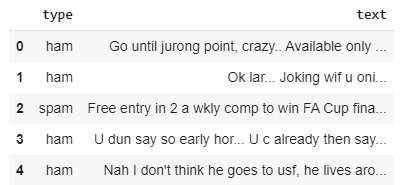

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

dfText = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/sms-spam.csv",
    sep = ',',
    thousands = None,
    decimal = '.',
    encoding='latin-1')

dfText.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#**Distribución de los datos**
En el siguiente bloque de código se muestra una gráfica donde se compara el número de mensajes _ham_ y _spam_ del _DataFrame_. 

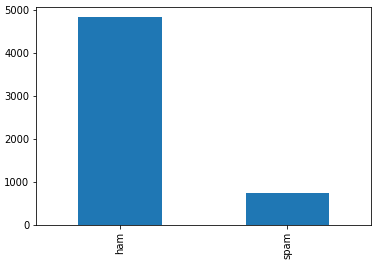

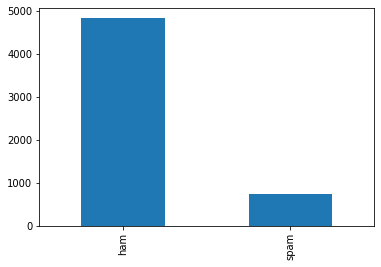

In [0]:
dfText.type.value_counts().plot.bar();

#**Acondicionamiento de los datos**
En esta Sección se acondicionan los datos para la construcción de los modelos de clasificación. 

##**Aplicación del STEMMER**
En el siguiente bloque de código, se aplica el _Stemmer_ para utilizar la raíz de las palabras de los mensajes y así normalizar los datos del texto. Las nuevas cadenas de texto que se obtienen luego de aplicar el _Stemmer_, se almacenan en una nueva columna del _DataFrame_ con nombre "stemmed".

In [0]:
#APLICAMOS EL STEMMER
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
dfText['stemmed'] = dfText.text.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))

##**Acondicionamiento de los datos de salida**
En el siguiente bloque de código, se transforman las salidas de tipo _ham_ y _spam_ como valores 1 o 0, 1 para _ham_ y 0 para _spam_. Estos nuevos valores se almacenan en una nueva columna del _DataFrame_ con nombre "type_binary".

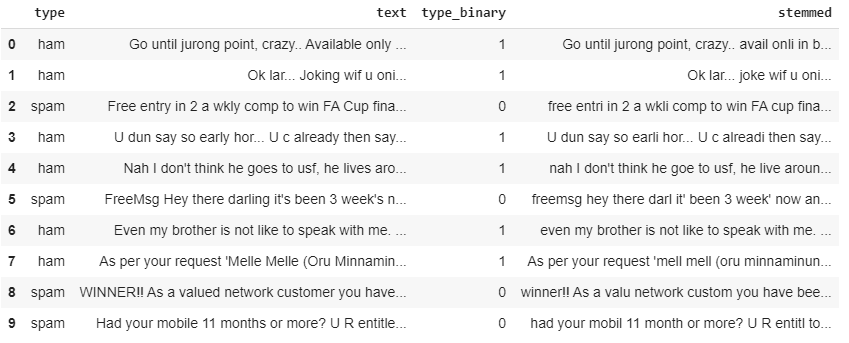

In [5]:
#CONVERTIMOS BINARIA LA SALIDA
type_binary = []
for tipo in dfText["type"]:
  if tipo == "ham":
    type_binary.append(1)
  else:
    type_binary.append(0)

dfText['type_binary'] = type_binary
dfText.head(10)

,type,text,type_binary,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...",1,"Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,1,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,1,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",1,"nah I don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,0,freemsg hey there darl it' been 3 week' now an...
6,ham,Even my brother is not like to speak with me. ...,1,even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,1,As per your request 'mell mell (oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,0,winner!! As a valu network custom you have bee...
9,spam,Had your mobile 11 months or more? U R entitle...,0,had your mobil 11 month or more? U R entitl to...


##**Acondicionamiento de los datos de entrada**
En el siguiente bloque de código, se utiliza la clase _CountVectorizer_ como implementación del _Bag-of-words_. Con esta clase, se transforma en vectores el texto de los mensajes con la presencia de cada palabra, 0 si no está presente y 1 si sí lo está. Estos vectores son las entradas para el entrenamiento y prueba de cada uno de los modelos a construir y evaluar.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

###BAG OF WORDS USANDO CONUT
count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5                # ignora palabras con baja freq
)

##
## Aplica la función al texto
##
dtm = count_vect.fit_transform(dfText.stemmed).toarray()
print(dtm)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#**Construcción y evaluación de modelos para el filtrado de mensajes spam**
En esta Sección se construyen y evalúan diferentes modelos para el filtrado de mensajes spam. Para comparar los resultados de cada modelo, se utiliza la métrica de la exactitud cuya ecuación es:
\begin{equation}
Exactitud = \frac{VP + VN}{VP + VN + FP + FN} 
\end{equation}
Donde VP es los verdaderos positivos; VN los verdaderos negativos; FP los falsos positivos; y, finalmente, FN los falsos negativos.

##**Construcción y evaluación del modelo de regresión logística**
En el siguiente bloque de código, se construye un modelo de regresión logística y se valida su robustez con _CrossValidation_ de 5 segmentos. 


In [0]:
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
exactitudTotalLogistica = 0
umbral = 0.1
#CROSS VALIDATION
segmentos = 5
pdSegmentosEntrada = np.array_split(dtm[0:], segmentos)
pdSegmentosSalida = np.array_split(dfText[["type_binary"]],segmentos)
regresionLogistica = linear_model.LogisticRegression()
#CROSSVALIDATION
matricesDeConfusion = []
for segmento in range (0, segmentos):
  pdEntradasTrain = []
  pdSalidasTrain = pd.DataFrame()

  for segmentoASeleccionar in range(0, segmentos):
    if segmentoASeleccionar != segmento:
      if len(pdEntradasTrain) == 0:
        pdEntradasTrain = pdSegmentosEntrada[segmentoASeleccionar].copy()
      else:
        pdEntradasTrain = np.concatenate((pdEntradasTrain, pdSegmentosEntrada[segmentoASeleccionar].copy()))    
      
      pdSalidasTrain = pdSalidasTrain.append(pdSegmentosSalida[segmentoASeleccionar].copy())   
    else:
      pdEntradasTest = pdSegmentosEntrada[segmentoASeleccionar].copy()
      pdSalidasTest = pdSegmentosSalida[segmentoASeleccionar].copy()
  
  regresionLogistica.fit(pdEntradasTrain, pdSalidasTrain.values.ravel())
  pronosticos = regresionLogistica.predict(np.array(pdEntradasTest))
  matricesDeConfusion.append(confusion_matrix(y_true = pdSalidasTest.copy(), y_pred = pronosticos))

matrizDeConfusionTotalLogistica = [[0, 0],[0, 0]]
for matrizDeConfusion in matricesDeConfusion:
  matrizDeConfusionTotalLogistica += matrizDeConfusion 
matrizDeConfusionTotalLogistica = matrizDeConfusionTotalLogistica / segmentos
#SUMAMOS LOS VALORES DE LA DIAGONAL
exactitudTotalLogistica = (matrizDeConfusionTotalLogistica[0][0] + matrizDeConfusionTotalLogistica [1][1]) / matrizDeConfusionTotalLogistica.sum()

###**Resultados**
Luego de construir y evaluar el modelo de regresión logística, se obtiene que la exactitud promedio de los 5 segmentos del _CrossValidation_ es de 98.22% aproximadamnete. Además, se muestra la matríz de confusión con los valores promedio para los 5 segmentos del _CrossValidation_.

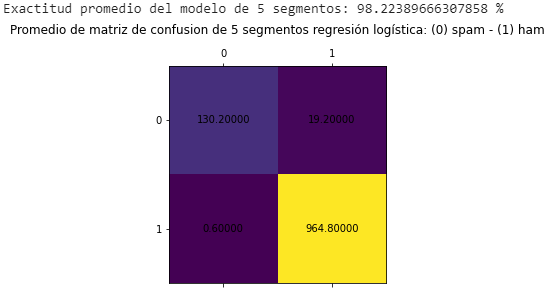

Exactitud promedio del modelo de 5 segmentos: 98.22389666307858 %


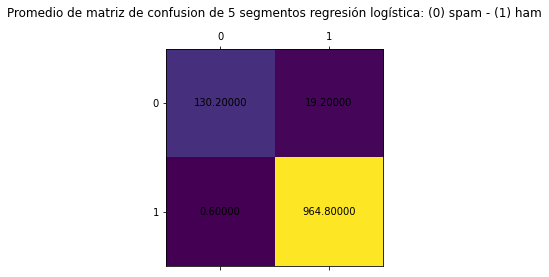

In [0]:
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(matrizDeConfusionTotalLogistica)
plt.title("Promedio de matriz de confusion de "+ str(segmentos) +" segmentos regresión logística: (0) spam - (1) ham\n")

for (i, j), z in np.ndenumerate(matrizDeConfusionTotalLogistica):
    ax.text(j, i, '{:0.5f}'.format(z), ha='center', va='center')

print("Exactitud promedio del modelo de "+ str(segmentos) +" segmentos: " +str(exactitudTotalLogistica*100)+ " %")

##**Construcción y evaluación de modelos de redes neuronales**
En el siguiente bloque de código, se construye y evalúan diferentes redes neuronales con función de activación logística y learning_rate 0.01. Se evalúan redes neuronales de 1 a 10 neuronas en la capa oculta con 5 segmentos de _CrossValidation_. El mejor modelo de redes neuronales se selecciona con la mayor exactitud promedio de estos segmentos.


In [0]:
import sklearn.neural_network
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix

exactitudTotal = 0
umbral = 0.1
#CROSS VALIDATION
segmentos = 5
pdSegmentosEntrada = np.array_split(dtm[0:], segmentos)
pdSegmentosSalida = np.array_split(dfText[["type_binary"]],segmentos)
for neuronasCapaOculta in range (1,11):
  mlp = sklearn.neural_network.MLPClassifier(
                  hidden_layer_sizes = (neuronasCapaOculta,),  # Una capa oculta con una neurona
                  activation = 'logistic',    #  {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
                  solver = 'sgd',             #  {‘lbfgs’, ‘sgd’, ‘adam’}
                  learning_rate_init = 0.01,   # Valor de la tasa de aprendizaje
                  learning_rate = 'constant', # La tasa no se adapta automáticamente
                  verbose = False,            # Reporte del proceso de optimización
                  shuffle = True,             #
                  tol = 1e-8,                 #
                  max_iter = 250000,
                  warm_start = True,          # Número máximo de iteraciones       
                  nesterovs_momentum = False) #

  matricesDeConfusion = []

  #CROSSVALIDATION
  for segmento in range (0, segmentos):
    pdEntradasTrain = []
    pdSalidasTrain = pd.DataFrame()

    for segmentoASeleccionar in range(0, segmentos):
      if segmentoASeleccionar != segmento:
        if len(pdEntradasTrain) == 0:
          pdEntradasTrain = pdSegmentosEntrada[segmentoASeleccionar].copy()
        else:
          pdEntradasTrain = np.concatenate((pdEntradasTrain, pdSegmentosEntrada[segmentoASeleccionar].copy()))    
        
        pdSalidasTrain = pdSalidasTrain.append(pdSegmentosSalida[segmentoASeleccionar].copy())   
      else:
        pdEntradasTest = pdSegmentosEntrada[segmentoASeleccionar].copy()
        pdSalidasTest = pdSegmentosSalida[segmentoASeleccionar].copy()
    
    mlp.fit(pdEntradasTrain, pdSalidasTrain.values.ravel())
    pronosticos = mlp.predict(np.array(pdEntradasTest))
    matricesDeConfusion.append(confusion_matrix(y_true = pdSalidasTest.copy(), y_pred = pronosticos))
  
  matrizDeConfusionTotalMLP = [[0, 0],[0, 0]]
  for matrizDeConfusion in matricesDeConfusion:
    matrizDeConfusionTotalMLP += matrizDeConfusion 
  matrizDeConfusionTotalMLP = matrizDeConfusionTotalMLP / segmentos
  #SUMAMOS LOS VALORES DE LA DIAGONAL
  exactitud = (matrizDeConfusionTotalMLP[0][0] + matrizDeConfusionTotalMLP [1][1]) / matrizDeConfusionTotalMLP.sum()
  if exactitud - exactitudTotal > umbral:
    exactitudTotal = exactitud
    matrizDeConfusionMLP = matrizDeConfusionTotalMLP.copy()
    mejorMLP = mlp
    neuronas = neuronasCapaOculta 

###**Resultados**
Luego de construir y evaluar los modelos de redes neuronales, se obtiene que el mejor modelo tiene una neurona en la capa oculta y una exactitud de 99.60% aproximadamnete. Además, se muestra la matríz de confusión con los valores promedio para los 5 segmentos del _CrossValidation_.

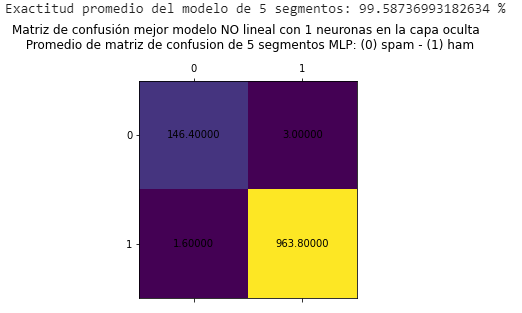

Exactitud promedio del modelo de 5 segmentos: 99.58736993182634 %


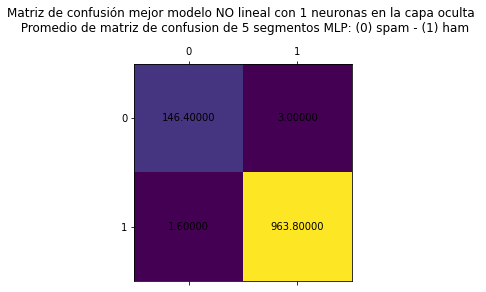

In [0]:
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(matrizDeConfusionMLP)
plt.title("Matriz de confusión mejor modelo NO lineal con "+ str(neuronas) +" neuronas en la capa oculta \n Promedio de matriz de confusion de "+ str(segmentos) +" segmentos MLP: (0) spam - (1) ham\n")

for (i, j), z in np.ndenumerate(matrizDeConfusionMLP):
    ax.text(j, i, '{:0.5f}'.format(z), ha='center', va='center')

print("Exactitud promedio del modelo de "+ str(segmentos) +" segmentos: " +str(exactitudTotal*100)+ " %")

#**Conclusión**
En este código se construyen y evalúan modelos para el filtrado de mensajes _spam_. Se elige la exactitud como métrica para elegir el mejor modelo para llevar a cabo el filtrado. Además, para asegurar la robustez de los modelos que se comparan, se implementa el _CrossValidation_ con 5 segmentos. Finalmente, el modelo de redes neuronales con una neurona en la capa oculta, supera en 1.4% aproximadamente en exactitud promedio de los 5 segmentos al modelo de regresión logística, por lo que se elige como mejor modelo la red neuronal.